In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm


## Bitcoin Price Prediction

In [3]:
train_data = pd.read_csv('datasets_1927_3320_bitcoin_price_Training - Training.csv')
train_data

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"
...,...,...,...,...,...,...,...
1551,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000"
1552,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000"
1553,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000"
1554,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000"


In [4]:
train_data.describe()

,Open,High,Low,Close
count,1556.000000,1556.000000,1556.000000,1556.000000
mean,582.625328,597.992847,567.851446,584.239396
std,523.137312,542.992855,505.877401,525.904442
min,68.500000,74.560000,65.530000,68.430000
25%,254.287500,260.327500,248.835000,254.320000
50%,438.600000,447.560000,430.570000,438.855000
75%,662.437500,674.525000,646.735000,663.402500
max,2953.220000,2999.910000,2840.530000,2958.110000


In [5]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

In [6]:
train_data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2017-07-31,2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,2017-07-30,2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,2017-07-29,2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,2017-07-28,2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,2017-07-27,2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


In [7]:
train_data.isnull().sum()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

In [8]:
data = train_data.set_index('Date')
data = data.sort_index()
data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2013-04-28,135.30,135.98,132.10,134.21,-,"1,500,520,000"
2013-04-29,134.44,147.49,134.00,144.54,-,"1,491,160,000"
2013-04-30,144.00,146.93,134.05,139.00,-,"1,597,780,000"
2013-05-01,139.00,139.89,107.72,116.99,-,"1,542,820,000"
2013-05-02,116.38,125.60,92.28,105.21,-,"1,292,190,000"


## Exploratory Data Analysis

Text(0, 0.5, 'Daily Bitcoin Prices')

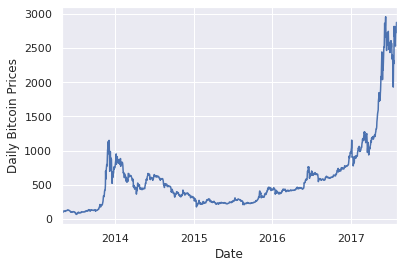

In [9]:
data['Close'].plot()
plt.ylabel('Daily Bitcoin Prices')

In [10]:
data = data['Close']

Text(0, 0.5, 'Weekly Bitcoin prices')

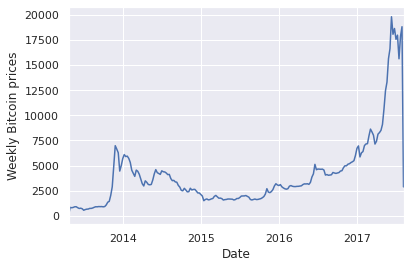

In [11]:
weekly_prices = data.resample('W').sum()
weekly_prices.plot()
plt.ylabel('Weekly Bitcoin prices')

Text(0, 0.5, 'Yearly Bitcoin prices')

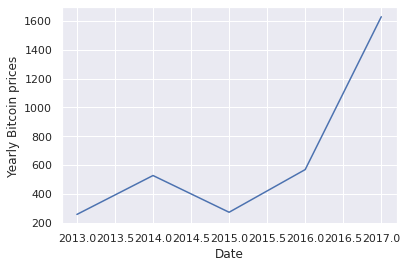

In [12]:
yearly_prices = data.groupby(data.index.year).mean()
yearly_prices.plot()
plt.ylabel('Yearly Bitcoin prices')

Text(0, 0.5, 'Bitcoin prices according to week days')

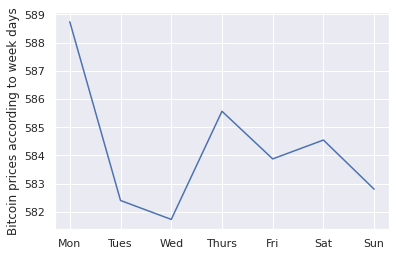

In [13]:
week_days = data.groupby(data.index.dayofweek).mean()
week_days.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
week_days.plot()
plt.ylabel('Bitcoin prices according to week days')

Text(0, 0.5, 'Days of the year Bitcoin prices')

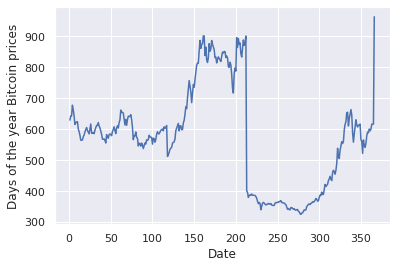

In [14]:
yearly_prices = data.groupby(data.index.dayofyear).mean()
yearly_prices.plot()
plt.ylabel('Days of the year Bitcoin prices')

Text(0, 0.5, 'Monthly Bitcoin prices')

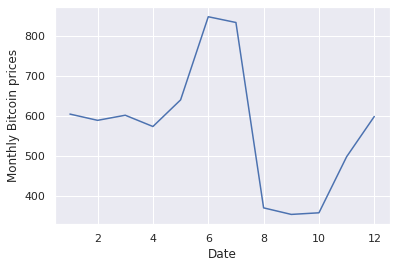

In [15]:
monthly = data.groupby(data.index.month).mean()
monthly.plot()
plt.ylabel('Monthly Bitcoin prices')

Text(0, 0.5, 'quarterly Bitcoin prices')

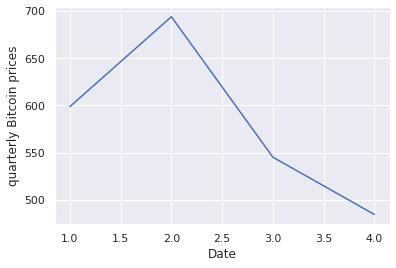

In [16]:
monthly = data.groupby(data.index.quarter).mean()
monthly.plot()
plt.ylabel('quarterly Bitcoin prices')

Text(0, 0.5, 'Overall quarterly Bitcoin prices')

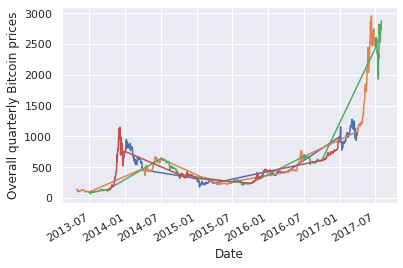

In [17]:
monthly = data.groupby(data.index.quarter)
monthly.plot()
plt.ylabel('Overall quarterly Bitcoin prices')

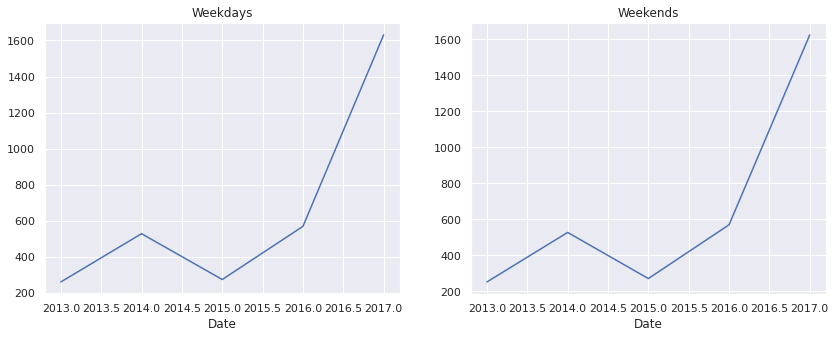

In [18]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.year]).mean()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays')
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends')

## Performing Dicky Fuller test

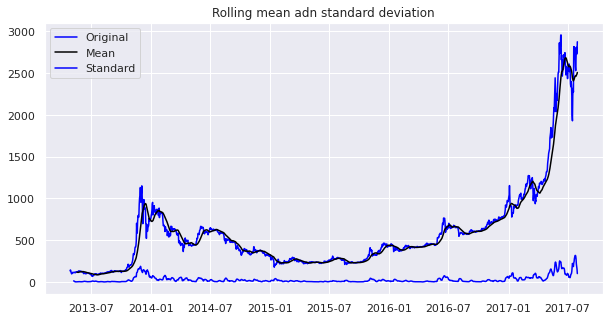

ADF statistics:  2.5355885873886206
p-value:  0.9990604352222925
Null hypothesis is accepted, The graph is stationery
Critical values:
	1%: -3.435 
	5%: -2.863 
	10%: -2.568 


In [19]:
def test_stationary(data):

    rolmean = data.rolling(window = 22, center = False).mean()
    rolstd = data.rolling(window = 12, center = False).std()
    plt.figure(figsize = (10,5))
    original = plt.plot(data, color = 'blue',label = 'Original')
    mean = plt.plot(rolmean,color = 'black',label = 'Mean')
    standard = plt.plot(rolstd,color = 'blue',label = 'Standard')
    plt.title('Rolling mean adn standard deviation')
    plt.legend(loc = 'best')
    plt.show(block = False)

    result = adfuller(data)
    print('ADF statistics: ',result[0])
    print('p-value: ',result[1])
    pvalue = result[1]

    if result[1]< 0.05:
        print("Null hypothesis is rejected, The graph is non stationery")
    else:
        print("Null hypothesis is accepted, The graph is stationery")

    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))

test_stationary(data)

## Finding the order of differencing or the 'd' value

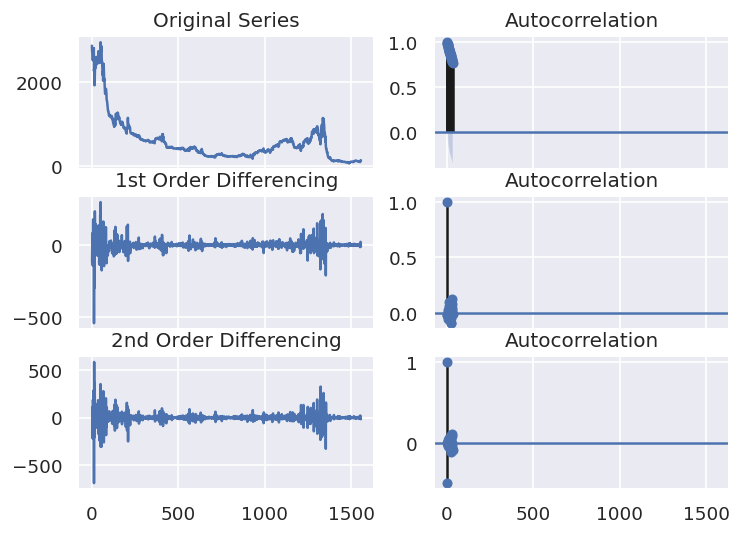

In [20]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_data.Close); axes[0, 0].set_title('Original Series')
plot_acf(train_data.Close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_data.Close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_data.Close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_data.Close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_data.Close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

## Finding The order of the AR term or p value

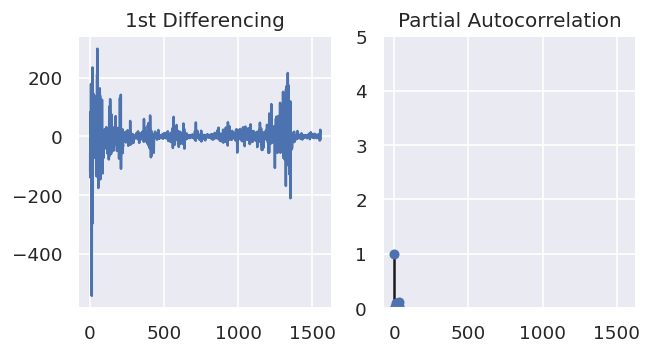

In [21]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_data.Close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train_data.Close.diff().dropna(), ax=axes[1])

plt.show()

## Finding the order of the MA term or the q value

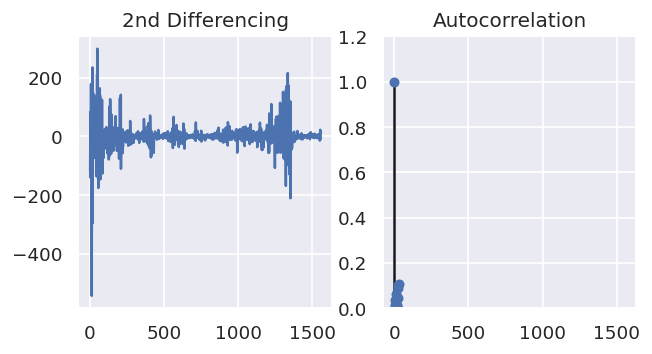

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_data.Close.diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train_data.Close.diff().diff().dropna(), ax=axes[1])

plt.show()

## Building SARIMA MODEL

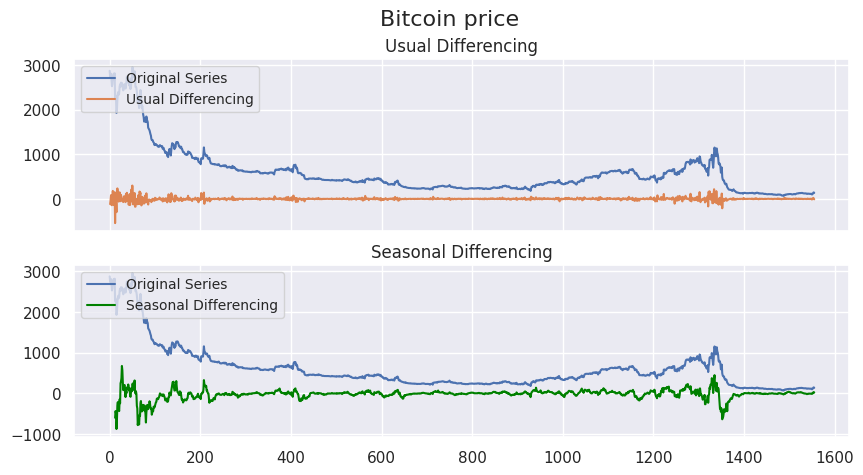

In [31]:
data = train_data['Close']
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Bitcoin price', fontsize=16)
plt.show()

In [32]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=2,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,1,1,2) [intercept=True]; AIC=15665.866, BIC=15692.609, Time=3.022 seconds
Fit ARIMA(0,0,0)x(0,1,0,2) [intercept=True]; AIC=16695.086, BIC=16705.783, Time=0.066 seconds
Fit ARIMA(1,0,0)x(1,1,0,2) [intercept=True]; AIC=16003.398, BIC=16024.792, Time=0.864 seconds
Fit ARIMA(0,0,1)x(0,1,1,2) [intercept=True]; AIC=15664.592, BIC=15685.987, Time=1.578 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 2); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,0,0)x(0,1,0,2) [intercept=False]; AIC=16699.889, BIC=16705.238, Time=0.046 seconds
Fit ARIMA(1,0,1)x(0,1,0,2) [intercept=True]; AIC=15664.759, BIC=15686.153, Time=1.083 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 0, 2); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,1)x(1,1,1,2) [intercept=True]; AIC=15668.718, BIC=15700.809, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1556
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 2)   Log Likelihood               -7828.296
Date:                           Wed, 01 Jul 2020   AIC                          15664.592
Time:                                   12:15:44   BIC                          15685.987
Sample:                                        0   HQIC                         15672.548
                                          - 1556                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.5263      1.882     -1.874      0.061      -7.215       0.162
ma.L1          1.0000      0.235      4.259      0.000       0.540       1.460
ma.S.L2       -0.0225      0.010     -2.306      0.021      -0.042      -0.003
sigma2      1383.0108    323.332      4.277      0.000     749.293    2016.729
===================================================================================
Ljung-Box (Q):                      171.23   Jarque-Bera (JB):             75375.33
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
n_periods = 70
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


## Forecasted Data

In [43]:
fitted

array([132.93352272, 130.69325519, 129.57297644, 127.16692533,
       126.04664658, 123.64059547, 122.52031672, 120.11426562,
       118.99398687, 116.58793576, 115.46765701, 113.0616059 ,
       111.94132715, 109.53527604, 108.4149973 , 106.00894619,
       104.88866744, 102.48261633, 101.36233758,  98.95628647,
        97.83600772,  95.42995662,  94.30967787,  91.90362676,
        90.78334801,  88.3772969 ,  87.25701815,  84.85096704,
        83.7306883 ,  81.32463719,  80.20435844,  77.79830733,
        76.67802858,  74.27197747,  73.15169872,  70.74564762,
        69.62536887,  67.21931776,  66.09903901,  63.6929879 ,
        62.57270915,  60.16665804,  59.0463793 ,  56.64032819,
        55.52004944,  53.11399833,  51.99371958,  49.58766847,
        48.46738972,  46.06133862,  44.94105987,  42.53500876,
        41.41473001,  39.0086789 ,  37.88840015,  35.48234904,
        34.36207029,  31.95601919,  30.83574044,  28.42968933,
        27.30941058,  24.90335947,  23.78308072,  21.37